## Tutorial3: Using SpatialMSI for Vertical Integration on Mouse Embryo ATAC Data

### 1. Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import SpatialMOSI

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

[1] "已设置北大阿里云镜像"


### 2. Load Data and Preprocess

In [2]:
from SpatialMOSI.utils import generate_spatial_graph,generate_csl_graph
Batch_list = []
adj_list = []
section_ids = ['E125_rep1','E135_rep1','E155_rep1']
adj_list = np.empty((2,0))
adj_list = adj_list.astype(int)
csl_list = np.empty((2,0))
csl_list = csl_list.astype(int)
n_obs_all = 0
for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad(f'Data/Dataset_mouse_embryo/{section_id}.h5ad')
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    adata.uns['adj']=generate_spatial_graph(adata, radius=3,self_loops=True) +n_obs_all
    adata.uns['edgecsl'] = generate_csl_graph(adata.n_obs, 5) + n_obs_all
    n_obs_all = n_obs_all + adata.n_obs
    csl_list = np.concatenate((csl_list, adata.uns['edgecsl']),axis = 1)
    adj_list = np.concatenate((adj_list, adata.uns['adj']),axis = 1)
    #sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=6000)
    #sc.pp.normalize_total(adata, target_sum=1e4)
    #sc.pp.log1p(adata)
    #adata = adata[:, adata.var['highly_variable']]
    Batch_list.append(adata)

E125_rep1
graph includs edges: 26920 average edges per node: 11.986
Negative spots selection completed!
E135_rep1
graph includs edges: 38586 average edges per node: 12.211
Negative spots selection completed!
E155_rep1
graph includs edges: 40002 average edges per node: 12.218
Negative spots selection completed!


In [3]:
from  SpatialMOSI.utils import  concat
adata_concat=concat(Batch_list, adj_list, csl_list,slice_ids=section_ids)

concat matrix shape: (8680, 248047)


In [4]:
from SpatialMOSI.utils import lsi
lsi(adata_concat,n_components=51)

### 3. Train

In [5]:
from SpatialMOSI.train import train_SpatialMSI
train_SpatialMSI(adata_concat, chr=True, alpha=1,hidden_dims=[40, 30], beta=1, pre_epochs=500, n_epochs=1000, show=False, k_csps= 40, device='cuda:7')

Pretraining


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 71.59it/s]


Training for multi slices...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.87it/s]


### 4. Clustering

In [8]:
sc.pp.neighbors(adata_concat, use_rep='embedding', random_state=666)
sc.tl.louvain(adata_concat, random_state=666, key_added="louvain", resolution=0.3)

### 5. Visulization

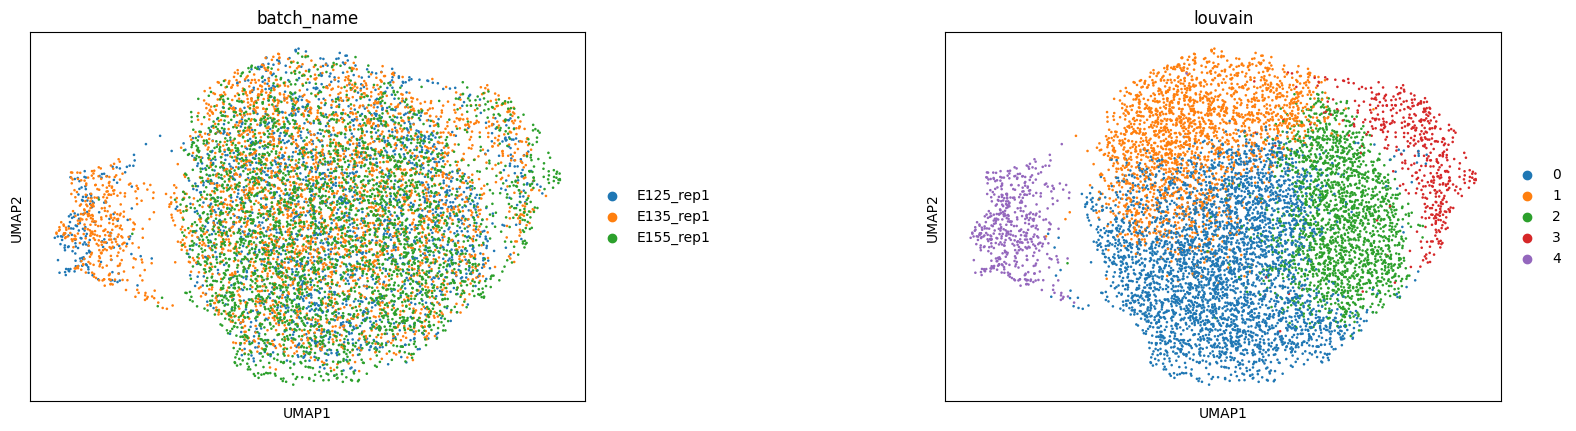

In [9]:
sc.tl.umap(adata_concat, random_state=666)
sc.pl.umap(adata_concat, color=['batch_name','louvain'], wspace=0.5,
           show=True)

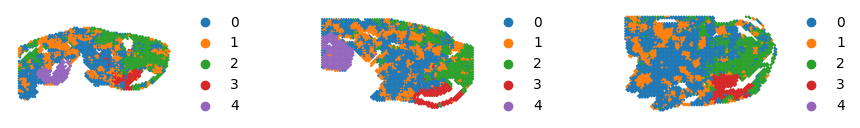

In [10]:
import scanpy as sc
Batch_list = []
section_ids=['E125_rep1','E135_rep1','E155_rep1']
for section_id in section_ids:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt

title_size = 12


fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.8, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['louvain'], title=[''],
                        show=False, ax=ax[0], frameon=False,
                      spot_size=2)

_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['louvain'], title=[''],
                        show=False, ax=ax[1], frameon=False,
                      spot_size=2)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['louvain'], title=[''],
                        show=False, ax=ax[2], frameon=False,
                      spot_size=2)

plt.show()